# Loading Models and Predicting Production

This code loads the trained XGBoost and LSTM models to make production predictions based on the state dataset. The XGBoost model provides predictions for the initial 260 days, while the LSTM model is used to extend these predictions for an additional 30 days.

## Steps:

1. **Import Necessary Modules**:
   - **`pandas`** and **`numpy`**: For data manipulation and numerical operations.
   - **`xgboost`**: To load the XGBoost model and make predictions.
   - **`matplotlib.pyplot`**: For plotting (if needed for visualizing results).
   - **`tensorflow.keras.models.load_model`**: To load the trained LSTM model.
   - **`update_production_with_prediction`** and **`preprocess_data`**: Custom functions for data processing and updating predictions.

2. **Load the Trained Models**:
   - **XGBoost Model**: Load the XGBoost model from a saved file (`xgboost_model.json`).
   - **LSTM Model**: Load the LSTM model from a saved file (`LSTM_model.h5`).

3. **Prepare Data for Prediction**:
   - Use the state dataset to prepare the input features. This dataset provides the static rock characteristics needed for predictions.

4. **Generate Initial Predictions**:
   - **XGBoost Model**: Predict production values (oil, water, gas) for the initial 260 days using the state dataset.

5. **Further Predictions with LSTM**:
   - **LSTM Model**: Use the output from the XGBoost model as input to the LSTM model to extend predictions for an additional 30 days.

6. **Update Production Data**:
   - Use the `update_production_with_prediction` function to incorporate the LSTM predictions into the production dataset, completing the forecast for the next 30 days.

This combined approach leverages the strengths of both models to provide a comprehensive forecast of production over a longer period.


In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from function import update_production_with_prediction, preprocess_data

2024-09-17 13:00:53.048949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Predicting Production with XGBoost

This section details the process of using a trained XGBoost model to predict production for a specific reservoir. The model is loaded, and predictions are made based on state data.

## Steps:

1. **Load the XGBoost Model**:
   - The pre-trained XGBoost model is loaded from a file (`xgboost_model.json`) using the `xgb.XGBRegressor()`.

2. **Load State Data for a Specific Reservoir**:
   - For a given reservoir (in this case, `reservoir_id` 96), the state data is loaded from a CSV file (`Reservoir96_state.csv`).

3. **Calculate Mean Values**:
   - Mean values are computed for relevant columns in the state data:
     - **X**
     - **Y**
     - **Depth**
     - **PERMX** (permeability in X direction)
     - **PERMY** (permeability in Y direction)
     - **PERMZ** (permeability in Z direction)
     - **PORO** (porosity)
     - **Transmissibility**
   - These mean values represent the static characteristics of the reservoir.

4. **Prepare Data for Prediction**:
   - A DataFrame is created for the prediction period (1 to 260 days), including:
     - **day**: Sequential days from 1 to 260.
     - **X**, **Y**, **Depth**, **PERMX**, **PERMY**, **PERMZ**, **PORO**, **Transmissibility**: All set to the mean values calculated earlier.

5. **Extract Relevant Features**:
   - The DataFrame is prepared with the features required by the XGBoost model for prediction.

6. **Predict Production**:
   - The XGBoost model is used to predict production values (oil, water, and gas) based on the prepared feature set.


In [2]:
# Load the XGBoost model
xg_boost_model = xgb.XGBRegressor()
xg_boost_model.load_model('xgboost_model.json')

reservoir_id = 96

# Load the state data for the reservoir
state_df = pd.read_csv(f'../../dataset/test/Reservoir{reservoir_id}_state.csv')

# Calculate mean values for the required columns in the state data
test_mean_values = state_df.agg({
    'X': 'mean',
    'Y': 'mean',
    'Depth': 'mean',
    'PERMX': 'mean',
    'PERMY': 'mean',
    'PERMZ': 'mean',
    'PORO': 'mean',
    'Transmissibility': 'mean'
}).to_dict()

# Create a DataFrame for the test data with days and mean values
days = pd.DataFrame({
    'day': list(range(1, 261)),
    **{col: mean for col, mean in test_mean_values.items()}
})

# Extract the relevant features for prediction
test_X_new = days[['X', 'Y', 'Depth', 'PERMX', 'PERMY', 'PERMZ', 'PORO', 'Transmissibility', 'day']]

# Predict the production using the XGBoost model
predict_production = xg_boost_model.predict(test_X_new)

# Organizing and Saving Prediction Results

This section organizes the prediction results from the XGBoost model and saves them to a CSV file for further analysis.

## Steps:

1. **Create Production DataFrame**:
   - Convert the predictions (`predict_production`) into a DataFrame (`production_df`).
   - Rename the columns to match the production metrics:
     - **Oil production cumulative**
     - **Water production cumulative**
     - **Gas production cumulative**

2. **Add Day Column**:
   - Add a `Day` column to the DataFrame with sequential values from 1 to the number of predictions, representing the days for which predictions are made.

3. **Reorder Columns**:
   - Reorder the columns to the desired format:
     - **Day**
     - **Gas production cumulative**
     - **Oil production cumulative**
     - **Water production cumulative**

4. **Save Results to CSV**:
   - Save the organized DataFrame (`predicted_production`) to a CSV file.
   - The file is saved in the `../Team200OK_test_results/` directory with a name indicating the reservoir ID (`Reservoir{reservoir_id}_production.csv`), where `{reservoir_id}` is replaced with the actual reservoir ID.

This ensures that the production predictions are well-organized and saved for subsequent use or analysis.


In [3]:
production_df = pd.DataFrame(predict_production)
production_df.columns = ['Oil production cumulative', 'Water production cumulative', 'Gas production cumulative']
predicted_production = production_df.copy()
predicted_production['Day'] = range(1, len(predicted_production) + 1)
predicted_production = predicted_production[['Day', 'Gas production cumulative', 'Oil production cumulative', 'Water production cumulative']]
predicted_production.to_csv(f"../Team200OK_test_results/Reservoir{reservoir_id}_production.csv", index=False)

# Recursive Prediction Function

This function is designed to recursively predict production values over multiple time steps using a trained model. It updates the production data iteratively based on previous predictions.

## Function Definition:


In [4]:
# Define a recursive prediction function with storage for multiple steps
def recursive_prediction(model, valid_X, production_test, n_steps):
    """Recursively predict production for multiple time steps."""
    all_predictions = []  # Store all predictions

    # Loop through the number of steps to recursively predict
    for step in range(n_steps):
        # Preprocess the current state of data
        X_sequences, y_sequences, X_scaled, y_scaled, scaler_X, scaler_y = preprocess_data(valid_X, production_test)

        # Make the prediction
        y_pred = model.predict(X_sequences)
        y = y_pred.reshape(-1, 3)  # Reshape the prediction
        y = scaler_y.inverse_transform(y)  # Inverse transform to get the original scale

        # Store the latest prediction
        all_predictions.append(y[-1].reshape(1, 3))

        # Update the production DataFrame with the latest prediction
        production_test = update_production_with_prediction(production_test, y[-1].reshape(1, 3))

    # Convert all_predictions to a NumPy array for easy manipulation
    all_predictions = np.vstack(all_predictions)

    return production_test, all_predictions

# Loading the LSTM Model and Making Recursive Predictions

In this section, we load a pre-trained LSTM model, perform recursive predictions to forecast future production, and save the results.

## Steps:

1. **Load the LSTM Model**:
   - Use `load_model` from TensorFlow to load the pre-trained LSTM model (`LSTM_model.h5`).

2. **Set the Number of Days to Predict**:
   - Define the number of days to forecast into the future (`predict_n_days`), set to 30 in this example.

3. **Perform Recursive Prediction**:
   - Call the `recursive_prediction` function to iteratively predict production values for the specified number of days.
   - Pass the LSTM model, state data (`state_df`), initial production data (`production_df`), and the number of days to predict.

4. **Convert Predictions to DataFrame**:
   - Convert the array of predictions (`all_predictions`) into a DataFrame (`predictions_df`) with columns:
     - **Oil production cumulative**
     - **Gas production cumulative**
     - **Water production cumulative**

5. **Save Predictions to CSV**:
   - Save the DataFrame to a CSV file with the name indicating the reservoir ID and prediction type.
   - The file is saved in the `/further_predict/` directory.

In [6]:
# Load the model
lstm_model = load_model('LSTM_model.h5')

# Set the number of days to predict
predict_n_days = 30

# Perform the recursive prediction
final_production_test, all_predictions = recursive_prediction(
    lstm_model, state_df, production_df, predict_n_days
)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=['Oil production cumulative', 'Gas production cumulative', 'Water production cumulative'])

# Save predictions to a CSV file
predictions_df.to_csv(f"../Team200OK_test_results/further_prediction/Reservoir{reservoir_id}_further_predict_production.csv", index=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━

# That's all the prediction

# Appendix
# Append Actual and Predicted Production Data

In this section, we will combine the actual and predicted production data to visualize and compare them.

## Steps:

1. **Concatenate Actual and Predicted Production Data**:
   - Combine the `production_df` (predicted data) and `predictions_df` (forecasted future data) into a single DataFrame (`predicted_data`).
   - Reset the index and select only the columns of interest: `Oil production cumulative`, `Water production cumulative`, and `Gas production cumulative`.
   - Add a `day` column with sequential day numbers.

2. **Load Actual Production Data**:
   - Load the actual production data from a CSV file.
   - Add a `day` column with sequential day numbers to match the structure of the predicted data.

3. **Visualize Actual vs Predicted Data**:
   - Use visualization libraries like `matplotlib` or `seaborn` to plot and compare the actual and predicted production values.

In [7]:
# Concatenate actual and predicted production data
predicted_data = pd.concat([production_df, predictions_df], axis=0).reset_index(drop=True)
predicted_data = predicted_data[['Oil production cumulative', 'Water production cumulative', 'Gas production cumulative']]
predicted_data['day'] = range(1, len(predicted_data) + 1)

## Replace actual production data

In [ ]:
# Load actual production data
actual = pd.read_csv('../../dataset/validation/Reservoir37/production.csv')
actual['day'] = range(1, len(actual) + 1)

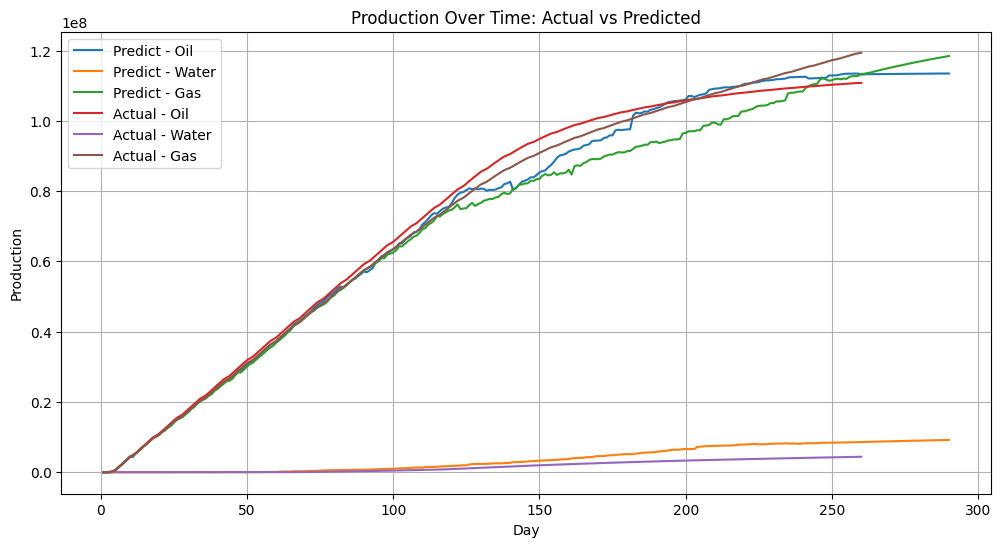

In [8]:
# Prepare to plot actual vs predicted production
plt.figure(figsize=(12, 6))

# Plot predicted production
plt.plot(predicted_data['day'], predicted_data['Oil production cumulative'], label='Predict - Oil')
plt.plot(predicted_data['day'], predicted_data['Water production cumulative'], label='Predict - Water')
plt.plot(predicted_data['day'], predicted_data['Gas production cumulative'], label='Predict - Gas')

# Plot actual production
plt.plot(actual['day'], actual['Oil production cumulative'], label='Actual - Oil')
plt.plot(actual['day'], actual['Water production cumulative'], label='Actual - Water')
plt.plot(actual['day'], actual['Gas production cumulative'], label='Actual - Gas')

# Customize plot
plt.xlabel('Day')
plt.ylabel('Production')
plt.title('Production Over Time: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()